In [1]:
import sys
sys.path.append('../cdsd')
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from data import *
import jams
%matplotlib inline

Double check the mAP and accuracy, and co-occurence
Listen to some examples
Look at masks converge during training, and also after (compare with ideal masks)

Leakage from other classes to jackhammer

Gunshot and dog bark should do very well

Also listen to examples

As a last result, frame-level results

Double check loss masking
Double check data pipeline


126K audio files
504K mask files

Potential Issues
* Scaper causing distortion in some sources? Maybe quantization noise?

In [9]:
#root_dir = "/home/jsondotload/projects/class-dependent-spl-decomposition/pishdadian2020-lambda5_soundscapes"
#train_config_path = "/home/jsondotload/projects/class-dependent-spl-decomposition/config.json"
root_dir = "/beegfs/jtc440/cdsd-data/pishdadian2020-lambda5_soundscapes"
train_config_path = "/scratch/jtc440/cdsd/models/orig/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen_lr1en4/config.json"
subset = 'train'

In [10]:
with open(train_config_path, 'r') as f:
    train_config = json.load(f)

In [11]:
input_transform = get_data_transforms(train_config)
test_dataset = CDSDDataset(root_dir, subset=subset, transform=input_transform, load_separation_data=True)

In [5]:
test_dataset.labels

['car_horn', 'dog_bark', 'gun_shot', 'jackhammer', 'siren']

In [6]:
test_dataset[0].keys()

dict_keys(['audio_data', 'clip_labels', 'frame_labels', 'index', 'energy_mask', 'num_events', 'mixture_waveform', 'car_horn_waveform', 'dog_bark_waveform', 'gun_shot_waveform', 'jackhammer_waveform', 'siren_waveform', 'car_horn_transformed', 'dog_bark_transformed', 'gun_shot_transformed', 'jackhammer_transformed', 'siren_transformed'])

In [7]:
clip_labels = []
frame_labels = []
for ex_idx in range(len(test_dataset.files)):
    ex = test_dataset.get_labels(ex_idx)
    clip_labels.append(ex['clip_labels'].numpy())
    frame_labels.append(ex['frame_labels'].numpy())

In [8]:
clip_labels = np.array(clip_labels)
frame_labels = np.array(frame_labels)

In [9]:
clip_labels.mean(axis=0)

array([0.6355 , 0.6356 , 0.6431 , 0.6387 , 0.63295], dtype=float32)

In [10]:
frame_labels.shape

(20000, 501, 5)

In [11]:
max_polyphony = frame_labels.sum(axis=-1).max(axis=-1).astype(int)

In [12]:
num_labels = clip_labels.shape[-1]
max_polyphony_counts = np.zeros((num_labels,))
for label_idx in range(num_labels):
    max_polyphony_counts[label_idx] = (max_polyphony == label_idx + 1).sum() / max_polyphony.shape[0]

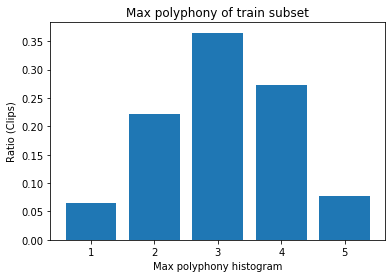

In [13]:
fig = plt.figure()
plt.bar(np.arange(num_labels) + 1, max_polyphony_counts)
plt.xlabel('Max polyphony histogram')
plt.ylabel('Ratio (Clips)')
plt.title('Max polyphony of train subset')
fig.patch.set_facecolor('white')

In [14]:
polyphony = frame_labels.sum(axis=-1).flatten().astype(int)
polyphony_counts = np.zeros((num_labels,))
for label_idx in range(num_labels):
    polyphony_counts[label_idx] = (polyphony == label_idx + 1).sum() / polyphony.shape[0]

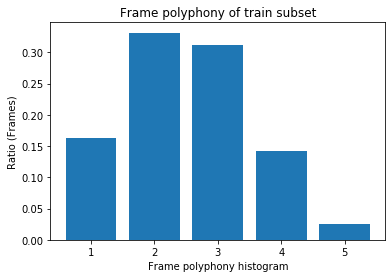

In [15]:
fig = plt.figure()
plt.bar(np.arange(num_labels) + 1, polyphony_counts)
plt.xlabel('Frame polyphony histogram')
plt.ylabel('Ratio (Frames)')
plt.title('Frame polyphony of train subset')
fig.patch.set_facecolor('white')

# Double check scaper distributions

In [56]:
import jams, librosa

In [59]:
label_distr_dict = {}
for fname in test_dataset.files:
    jams_path = os.path.join(root_dir, subset, fname + '.jams')
    jams_obj = jams.load(jams_path)

    # Compute clip and frame level labels
    for ann in jams_obj.annotations[0].data:
        if ann.value['role'] == "foreground":
            label = ann.value['label']
            audio_path = ann.value['source_file']
            waveform_dur = librosa.get_duration(filename=audio_path)

            allowed_start_times = max(4.0 - waveform_dur, 0)
            if allowed_start_times > 0:
                rel_start_time = ann.value['event_time'] / allowed_start_times
            else:
                rel_start_time = 0.0
            
            if label not in label_distr_dict:
                label_distr_dict[label] = {
                    'event_time': [],
                    'event_rel_time': [],
                    'event_duration': [],
                    'snr': [],
                    'num_full_events': 0,
                    'num_events': 0,
                }
                
            label_distr_dict[label]['event_time'].append(ann.value['event_time'])
            label_distr_dict[label]['event_rel_time'].append(rel_start_time)
            label_distr_dict[label]['event_duration'].append(ann.value['event_duration'])
            label_distr_dict[label]['snr'].append(ann.value['snr'])
            
            if waveform_dur >= 4.0:
                label_distr_dict[label]['num_full_events'] += 1
                
            label_distr_dict[label]['num_events'] += 1


In [60]:
for idx, label in enumerate(test_dataset.labels):
    ratio = label_distr_dict[label]['num_full_events'] / label_distr_dict[label]['num_events']
    print("{}: {}".format(label, ratio))

car_horn: 0.38075874039176794
dog_bark: 0.6521760633036597
gun_shot: 0.005253684876197889
jackhammer: 0.7768766689743843
siren: 0.9329902058764741


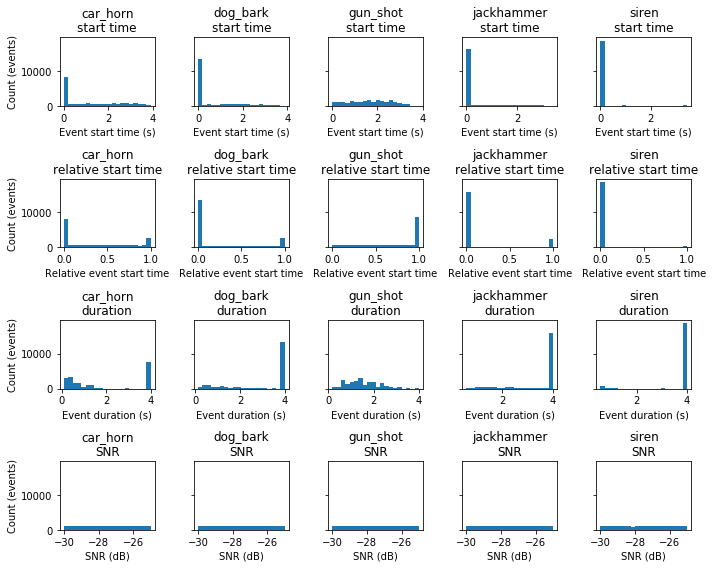

In [58]:
fig, axes = plt.subplots(ncols=num_labels,
                         nrows=4,
                         figsize=(10,8),
                         sharey=True)

for idx, label in enumerate(test_dataset.labels):
    ax = axes[0, idx]
    ax.hist(label_distr_dict[label]['event_time'], bins=20)
    if idx == 0:
        ax.set_ylabel('Count (events)')
    ax.set_xlabel('Event start time (s)')
    ax.set_title('{}\nstart time'.format(label))

for idx, label in enumerate(test_dataset.labels):
    ax = axes[1, idx]
    ax.hist(label_distr_dict[label]['event_rel_time'], bins=20)
    if idx == 0:
        ax.set_ylabel('Count (events)')
    ax.set_xlabel('Relative event start time')
    ax.set_title('{}\nrelative start time'.format(label))
    
for idx, label in enumerate(test_dataset.labels):
    ax = axes[2, idx]
    ax.hist(label_distr_dict[label]['event_duration'], bins=20)
    if idx == 0:
        ax.set_ylabel('Count (events)')
    ax.set_xlabel('Event duration (s)')
    ax.set_title('{}\nduration'.format(label))
    
for idx, label in enumerate(test_dataset.labels):
    ax = axes[3, idx]
    ax.hist(label_distr_dict[label]['snr'], bins=20)
    if idx == 0:
        ax.set_ylabel('Count (events)')
    ax.set_xlabel('SNR (dB)')
    ax.set_title('{}\nSNR'.format(label))
    
plt.tight_layout()
fig.patch.set_facecolor('white')

# Check audio loading

In [18]:
import soundfile as sf

In [10]:
audio_path = os.path.join(test_dataset.data_dir, test_dataset.files[0] + '.wav')

In [24]:
ta_audio, sr = torchaudio.load(audio_path)
ta_audio = ta_audio.numpy()

In [28]:
sf_audio, sr = sf.read(audio_path)

In [29]:
np.abs(sf_audio - ta_audio).max()

0.0

# Check spectrograms

In [7]:
from torchaudio.functional import magphase, spectrogram

In [8]:

# get STFT parameters:
params = {}
for transform_config in train_config["input_transforms"]:
    if transform_config["name"] != 'Spectrogram':
        continue
    params = transform_config["parameters"]
    break
spec_params = {
    "pad": params.get("pad", 0),
    "n_fft": params.get("n_fft", 400),
    "power": params.get("power", 2.0),
    "normalized": params.get("normalized", False),
    "window_fn": get_torch_window_fn(params.get("window_fn", "hann_window")),
    "wkwargs": params.get("wkwargs", {})
}
spec_params["win_length"] = params.get("win_length") or spec_params["n_fft"]
spec_params["hop_length"] = params.get("hop_length") or (spec_params["win_length"] // 2)

ex_idx = 4
sample = test_dataset[ex_idx]
fname = test_dataset.files[ex_idx]

x = sample["audio_data"][None, ...]
mixture_waveforms = sample["mixture_waveform"][None, ...]

# Compute cosine and sine of phase spectrogram for reconstruction
mixture_maggram, mixture_phasegram = magphase(spectrogram(
    mixture_waveforms,
    pad=spec_params["pad"],
    window=spec_params["window_fn"](
        window_length=spec_params["win_length"],
        **spec_params["wkwargs"]),
    n_fft=spec_params["n_fft"],
    hop_length=spec_params["hop_length"],
    win_length=spec_params["win_length"],
    power=None,
    normalized=spec_params["normalized"]), power=1.0)

# Sanity check
assert torch.allclose(x, mixture_maggram, atol=1e-8)

# Check STFT vs Scipy

Differences:
* Scipy hann uses symmetric by default, pytorch uses periodic by default
    * Add "periodic=False" in wkwargs in config
* Scipy zero pads at the end to fit the last window, pytorch pads by win_length // 2 on both sides using reflection padding
    * Have to make custom transform object

Things to add

In [9]:
import h5py

In [10]:
samp_stfts = h5py.File('../samp_stfts.hdf5')

/home/jtc440/miniconda3/envs/cdsd/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [11]:
# <KeysViewHDF5 ['children', 'dog', 'engin', 'music', 'siren']>

In [12]:
samp_stfts.keys()

<KeysViewHDF5 ['aud_original', 'istft', 'stft']>

In [13]:
db_audio = samp_stfts['aud_original']['children'][()]
db_stft = samp_stfts['stft']['children'][()]
db_istft = samp_stfts['istft']['children'][()]

In [14]:
db_audio_pt = torch.tensor(db_audio)[None, None, :]

In [77]:
pt_sqrt_hann = spec_params["window_fn"](
        window_length=spec_params["win_length"],
        **spec_params["wkwargs"]).numpy()
pt_scale = pt_sqrt_hann.sum()

In [135]:
db_stft_pt = spectrogram(
    db_audio_pt,
    pad=spec_params["pad"],
    window=spec_params["window_fn"](
        window_length=spec_params["win_length"],
        **spec_params["wkwargs"]),
    n_fft=spec_params["n_fft"],
    hop_length=spec_params["hop_length"],
    win_length=spec_params["win_length"],
    power=None,
    normalized=spec_params["normalized"],)
db_stft_pt_orig = (db_stft_pt / pt_scale).float()
db_stft_pt = db_stft_pt.squeeze().transpose(0,1).numpy()
db_stft_pt = db_stft_pt[..., 0] + 1j * db_stft_pt[..., 1]
db_stft_pt /= pt_scale

In [140]:
db_istft_pt = torchaudio.functional.istft(
    db_stft_pt_orig,
    window=spec_params["window_fn"](
    window_length=spec_params["win_length"], **spec_params["wkwargs"]).float(),
    n_fft=spec_params["n_fft"],
    hop_length=spec_params["hop_length"],
    win_length=spec_params["win_length"],
    normalized=spec_params["normalized"],
    onesided=True,
    center=True,
    pad_mode="reflect"
)
db_istft_pt = db_istft_pt.squeeze().numpy()
db_istft_pt *= pt_scale


In [142]:
np.abs(db_istft_pt - db_istft).sum()

0.0006064918896843824

In [115]:
np.abs(db_stft - db_stft_pt).min()

2.503552920529728e-14

In [113]:
np.linalg.norm((db_stft - db_stft_pt).flatten(), ord=1)

2.4620418970825275

In [116]:
np.linalg.norm((db_stft - db_stft_sp.T).flatten(), ord=1)

4.579226962552471e-06

In [16]:
def stft_sp(waveform,
        window,
        n_fft,
        hop_length,
        win_length,
        power,
        normalized):

    waveform = torch.nn.functional.pad(waveform, (0, win_length), "constant")

    # pack batch
    shape = waveform.size()
    waveform = waveform.view(-1, shape[-1])

    # default values are consistent with librosa.core.spectrum._spectrogram
    # waveform, n_fft, hop_length, win_length, window, center, pad_mode, normalized, onesided,
    spec_f = torch.stft(
        waveform, n_fft, hop_length, win_length, window, False, "constant", False, True
    )

    # unpack batch
    spec_f = spec_f.view(shape[:-1] + spec_f.shape[-3:])

    if normalized:
        spec_f /= window.pow(2.).sum().sqrt()
    if power is not None:
        spec_f = complex_norm(spec_f, power=power)

    return spec_f


In [17]:
# db_stft_ptsp = stft_sp(
#     db_audio_pt,
#     window=spec_params["window_fn"](
#         window_length=spec_params["win_length"],
#         **spec_params["wkwargs"]),
#     n_fft=spec_params["n_fft"],
#     hop_length=spec_params["hop_length"],
#     win_length=spec_params["win_length"],
#     power=None,
#     normalized=spec_params["normalized"],)
# db_stft_ptsp = db_stft_ptsp.squeeze().transpose(0,1).numpy()
# db_stft_ptsp = db_stft_ptsp[..., 0] + 1j * db_stft_ptsp[..., 1]

In [18]:
import scipy

In [68]:
sp_sqrt_hann = np.sqrt(scipy.signal.hann(spec_params["win_length"], sym=False))


In [66]:
_, _, db_stft_sp = scipy.signal.stft(
    db_audio,
    fs=SAMPLE_RATE,
    window=sp_sqrt_hann,
    nperseg=spec_params["win_length"],
    noverlap=(spec_params["win_length"]-spec_params["hop_length"]),
    nfft=spec_params["win_length"],
    detrend=False,
    return_onesided=True,
    boundary='zeros',
    padded=True, axis=-1)

In [67]:
db_stft_pt - db_stft

array([[ 1.16064847e+01+0.00000000e+00j,  4.21727586e+00-1.82701840e-02j,
        -1.04460005e+01-4.63518683e-03j, ...,
         6.23740398e-02+3.73088541e-06j, -5.86432143e-02-1.53146212e-06j,
         5.90899279e-02+0.00000000e+00j],
       [ 1.08584952e+01+0.00000000e+00j, -9.74479834e+00+5.01903570e+00j,
         6.65486914e+00-4.89883202e+00j, ...,
        -4.41496446e-02+1.63078950e-03j,  3.93316185e-04+4.10423170e-02j,
         4.23107142e-02+0.00000000e+00j],
       [ 6.55945100e+00+0.00000000e+00j, -5.10785938e+00-1.10736187e+01j,
        -1.34539248e+00+4.17125761e+00j, ...,
         3.04012469e-04-3.27490560e-04j, -1.52057567e-03-8.27506440e-04j,
         1.79355937e-03+0.00000000e+00j],
       ...,
       [ 2.16095086e+00+0.00000000e+00j, -4.96834335e+01+1.22855086e+02j,
         3.51696523e+01-4.68584268e+01j, ...,
        -1.07696236e-02+2.98140714e-03j,  1.49713406e-03+1.15836649e-02j,
         1.27400219e-02+0.00000000e+00j],
       [ 6.31631515e+01+0.00000000e+00j, -7.

# Examine isolated sources

In [19]:
ex_idx = 8
normalize = True
sample = test_dataset[ex_idx]
fname = test_dataset.files[ex_idx]
print("File: " + fname)
print("============================================================")
print("Mixture:")
display(Audio(data=sample['mixture_waveform'], rate=SAMPLE_RATE, normalize=normalize))

print("\nPresent Sources")
print("------------------")
for label_idx in sample['labels'].nonzero().flatten().tolist():
    label = test_dataset.labels[label_idx]
    print(label + ":")
    display(Audio(data=sample[label + '_waveform'], rate=SAMPLE_RATE, normalize=normalize))

print("\nMissing Sources")
print("------------------")
for label_idx in (1 - sample['labels']).nonzero().flatten().tolist():
    label = test_dataset.labels[label_idx]
    print(label + ":")
    display(Audio(data=sample[label + '_waveform'], rate=SAMPLE_RATE, normalize=normalize))


File: soundscape_test_pishdadidan2020_lambda5_1611
Mixture:



Present Sources
------------------
car_horn:


dog_bark:


gun_shot:


siren:



Missing Sources
------------------
jackhammer:


# Look at individual events

In [16]:
jams_path = os.path.join(root_dir, subset, fname + '.jams')

In [17]:
jams_obj = jams.load(jams_path)

In [18]:
jams_obj

duration,4.0
original_duration,4.0
fg_path,/beegfs/jtc440/cdsd-data/us8k-foreground/test
bg_path,/beegfs/jtc440/sonyc_ust_spl_decomposition/background_clips_70/2017
fg_spec,choosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNone
bg_spec,
fg_labels,air_conditionercar_hornchildren_playingdog_barkdrillingengine_idlinggun_shotjackhammersirenstreet_music
bg_labels,sonycnode-b827eb0d8af7.sonyc_recording_indexsonycnode-b827eb0fedda.sonyc_recording_indexsonycnode-b827eb122f0f.sonyc_recording_indexsonycnode-b827eb132382.sonyc_recording_indexsonycnode-b827eb1685c7.sonyc_recording_indexsonycnode-b827eb241343.sonyc_recording_indexsonycnode-b827eb252949.sonyc_recording_indexsonycnode-b827eb29eb77.sonyc_recording_indexsonycnode-b827eb2a1bce.sonyc_recording_indexsonycnode-b827eb2c65db.sonyc_recording_indexsonycnode-b827eb329ab8.sonyc_recording_indexsonycnode-b827eb32e075.sonyc_recording_indexsonycnode-b827eb429cd4.sonyc_recording_indexsonycnode-b827eb42bd4a.sonyc_recording_indexsonycnode-b827eb43d8f4.sonyc_recording_indexsonycnode-b827eb44506f.sonyc_recording_indexsonycnode-b827eb4cc22e.sonyc_recording_indexsonycnode-b827eb4e7821.sonyc_recording_indexsonycnode-b827eb539980.sonyc_recording_indexsonycnode-b827eb5895e9.sonyc_recording_indexsonycnode-b827eb73e772.sonyc_recording_indexsonycnode-b827eb815321.sonyc_recording_indexsonycnode-b827eb820cfe.sonyc_recording_indexsonycnode-b827eb86d458.sonyc_recording_indexsonycnode-b827eb8e2420.sonyc_recording_indexsonycnode-b827eb905497.sonyc_recording_indexsonycnode-b827eb9b859c.sonyc_recording_indexsonycnode-b827eb9bed23.sonyc_recording_indexsonycnode-b827eb9d0e7f.sonyc_recording_indexsonycnode-b827ebad073b.sonyc_recording_indexsonycnode-b827ebb40450.sonyc_recording_indexsonycnode-b827ebba613d.sonyc_recording_indexsonycnode-b827ebc6dcc6.sonyc_recording_indexsonycnode-b827ebc7f772.sonyc_recording_indexsonycnode-b827ebdd5c38.sonyc_recording_indexsonycnode-b827ebe1fe4b.sonyc_recording_indexsonycnode-b827ebefb215.sonyc_recording_indexsonycnode-b827ebf31214.sonyc_recording_indexsonycnode-b827ebf9d204.sonyc_recording_indexsonycnode-b827ebfd616c.sonyc_recording_index
protected_labels,car_horndog_barkgun_shotjackhammersiren
sr,16000
ref_db,0


In [11]:
import soundfile as sf
audio, sr = sf.read('../128470-3-0-5.wav')
audio = audio.mean(axis=-1).astype('float32')

RuntimeError: Error opening '../128470-3-0-5.wav': System error.

In [ ]:
original_scale = np.abs(audio).max()
target_scale = np.abs(sample['dog_bark_waveform'].numpy()).max()
rescaled_audio_1 = audio / original_scale
rescaled_audio_2 = rescaled_audio * target_scale

In [ ]:
from scaper.audio import get_integrated_lufs

In [ ]:
-78.22176208650802 - get_integrated_lufs('../128470-3-0-5.wav')

In [ ]:
Audio(audio, rate=sr)

In [ ]:
audio_rs, sr = sf.read('../rescaled_dog.wav')
audio_rs = audio_rs.mean(axis=-1)
Audio(audio_rs, rate=sr)

In [ ]:
dog_path = os.path.join(root_dir, subset, fname + "_events", "foreground2_dog_bark.wav")
audio2, sr = sf.read(dog_path)
Audio(audio2, rate=SAMPLE_RATE)

In [ ]:
Audio(rescaled_audio_2, rate=SAMPLE_RATE)

# Double check distribution of events per clip

(5.0322, 4.82076316)


Text(0.5, 1.0, 'Distribution of events')

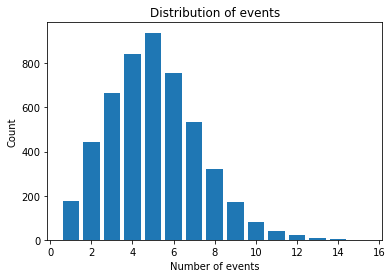

In [13]:
num_events_list = [int(x['num_events'].item()) for x in test_dataset]
vals = sorted(set(num_events_list))
counts = {x: 0 for x in vals}
for x in num_events_list:
    counts[x] += 1
counts = [counts[x] for x in vals]

print((np.mean(num_events_list), np.var(num_events_list)))

plt.bar(vals, counts)
plt.xlabel('Number of events')
plt.ylabel('Count')
plt.title('Distribution of events')

Text(0.5, 1.0, 'Empirical distribution of zero-truncated Poisson (lambda = 5)')

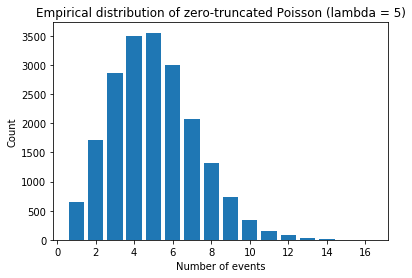

In [45]:
from generate_mixtures import sample_ztpoisson
ztp_counts = {}
ztp_max = 0
lmbda = 5
for _ in range(20000):
    x = sample_ztpoisson(lmbda)
    if x not in ztp_counts:
        ztp_counts[x] = 1
    else:
        ztp_counts[x] += 1
        
    ztp_max = max(x, ztp_max)
    
for x in range(1, ztp_max + 1):
    if x not in ztp_counts:
        ztp_counts[x] = 0
ztp_counts = [ztp_counts[x] for x in np.arange(1, ztp_max+1)]
plt.bar(np.arange(1, ztp_max+1), ztp_counts)
plt.xlabel('Number of events')
plt.ylabel('Count')
plt.title('Empirical distribution of zero-truncated Poisson (lambda = {})'.format(lmbda))

# Double check the distribution of event types per example

(3.179, 1.108559)


Text(0.5, 1.0, 'Distribution of event types')

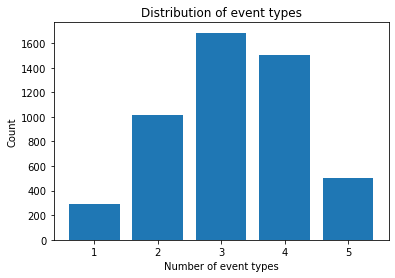

In [49]:
num_event_type_list = [int(x['labels'].sum().item()) for x in test_dataset]

vals = sorted(set(num_event_type_list))
counts = {x: 0 for x in vals}
for x in num_event_type_list:
    counts[x] += 1
counts = [counts[x] for x in vals]

print((np.mean(num_event_type_list), np.var(num_event_type_list)))

plt.bar(vals, counts)
plt.xlabel('Number of event types')
plt.ylabel('Count')
plt.title('Distribution of event types')

# Check frame level probabilities for each class

In [22]:
input_transform = get_data_transforms(train_config)
train_dataset = CDSDDataset(root_dir, subset='train', transform=input_transform, load_separation_data=True, label_mode='frame')

In [23]:
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram, MelScale, Spectrogram

In [32]:
total_num_frames = 0
label_frame_counts = None
num_events_list = []

for file in train_dataset.files:
    jams_path = os.path.join(root_dir, 'train', file + '.jams')
    jams_obj = jams.load(jams_path)

    hop_length = 1
    win_length = 1

    for t in input_transform.transforms:
        # There should only be at most one transform that
        # effects the time dimension (since we don't allow
        # the resample transformation)
        if isinstance(t, Spectrogram) or isinstance(MelSpectrogram):
            hop_length = t.hop_length
            win_length = t.win_length

    # Account for centering
    pad_ts = (win_length // 2) / SAMPLE_RATE

    hop_ts = hop_length / SAMPLE_RATE
    num_frames = 501

    label_arr = torch.zeros(num_frames, train_dataset.num_labels)
    num_events = torch.zeros(1, dtype=torch.int16)
    for ann in jams_obj.annotations[0].data:
        if ann.value['role'] == "foreground":
            start_ts = ann.value['event_time']
            end_ts = start_ts + ann.value['event_duration']

            # Compute frame indices, such that each frame contains
            # the source
            start_idx = int((start_ts - pad_ts + hop_ts) * SAMPLE_RATE / hop_length)
            start_idx = max(0, start_idx)
            end_idx = int(np.ceil((end_ts + pad_ts) * SAMPLE_RATE / hop_length))
            end_idx = min(num_frames, end_idx)


            label = ann.value['label']
            label_idx = train_dataset.label_to_idx[label]
            label_arr[start_idx:end_idx, label_idx] = 1.0
            num_events += 1
            
    total_num_frames += x['labels'].shape[0]
    ex_counts = label_arr.sum(axis=0).numpy()
    if label_frame_counts is None:
        label_frame_counts = ex_counts
    else:
        label_frame_counts += ex_counts
        
    num_events_list.append(num_events.item())
label_frame_probs = label_frame_counts / total_num_frames

In [20]:
label_frame_probs

array([0.38827545, 0.53760709, 0.31754182, 0.59567595, 0.61354651])

(5.0588, 4.83264256)


Text(0.5, 1.0, 'Distribution of events')

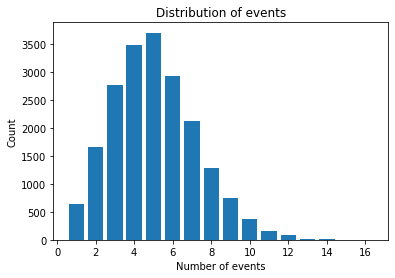

In [33]:
vals = sorted(set(num_events_list))
counts = {x: 0 for x in vals}
for x in num_events_list:
    counts[x] += 1
counts = [counts[x] for x in vals]

print((np.mean(num_events_list), np.var(num_events_list)))

plt.bar(vals, counts)
plt.xlabel('Number of events')
plt.ylabel('Count')
plt.title('Distribution of events')

# Double check frame-level targets

In [264]:
import numpy as np
from interval import interval

sample_rate = 16000
clip_duration_ts = 4.0

event_start_ts = 0.777777
event_end_ts = 2.2353457
event_interval = interval[event_start_ts, event_end_ts]

hop_length = 128
win_length = 512

# Construct test signal
test_arr = np.zeros((int(sample_rate * clip_duration_ts),))

# Pad for centering
pad = win_length // 2
test_arr = np.pad(test, (pad, pad))

pad_ts = pad / SAMPLE_RATE
hop_ts = hop_length / SAMPLE_RATE
win_ts = win_length / SAMPLE_RATE

num_frames = (test.shape[0] - win_length) // hop_length + 1


# Compute intersections of frame intervals with event intervals
test_y1 = np.zeros((num_frames,))
flag = True
for frame_idx in range(num_frames):
    frame_start_ts = frame_idx * hop_ts - pad_ts
    frame_end_ts = frame_start_ts + win_ts
    
    frame_interval = interval[frame_start_ts, frame_end_ts]
    intersection = (frame_interval & event_interval)
    if len(intersection.extrema) > 1:
        #print(frame_idx, frame_start_ts, frame_end_ts, intersection)
        test_y1[frame_idx] = 1
        
frame_start_idx_1, frame_end_idx_1 = test_y1.nonzero()[0][[0, -1]]
print((frame_start_idx_1, frame_end_idx_1 + 1))


frame_start_idx = int((event_start_ts - pad_ts + hop_ts) * sample_rate / hop_length)
frame_start_idx = max(0, frame_start_idx)

frame_end_idx = int(np.ceil((event_end_ts + pad_ts) * sample_rate / hop_length))
frame_end_idx = min(num_frames, frame_end_idx)
print((frame_start_idx, frame_end_idx))


(96, 282)
(96, 282)


# Check energy masking

In [22]:
from librosa.display import specshow

Text(0, 0.5, '            ')

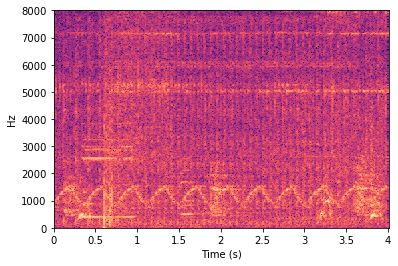

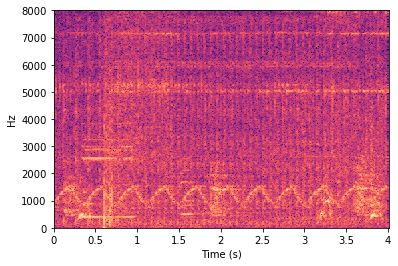

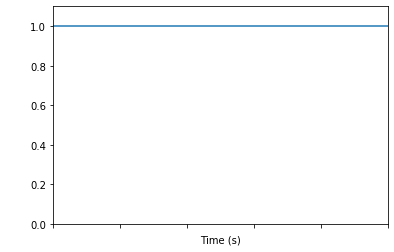

In [69]:
# Get example
idx_list = []
for ex_idx in range(len(test_dataset)):
    x = test_dataset[ex_idx]['audio_data'][None, ...]
    # Compute mask
    batch_size, n_channel, n_freq, n_time = x.size()
    frame_energy = x.sum(dim=2, keepdim=True)
    threshold = frame_energy.max(dim=3, keepdim=True)[0] * 0.01
    energy_mask = (frame_energy >= threshold).float()

    if (energy_mask < 0.5).max().item():
        idx_list.append(ex_idx)


Text(0, 0.5, '            ')

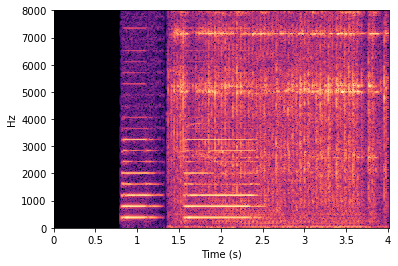

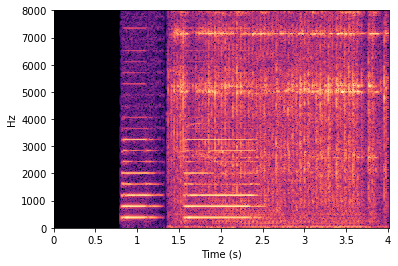

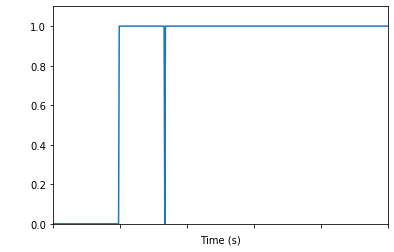

In [74]:
ex_idx = idx_list[3]

sample = test_dataset[ex_idx]
fname = test_dataset.files[ex_idx]

#display(Audio(data=sample['mixture_waveform'], rate=SAMPLE_RATE, normalize=normalize))
spec = sample['audio_data']
logspec_np = librosa.amplitude_to_db(spec.squeeze().numpy())


x = spec[None, ...]

# Compute mask
batch_size, n_channel, n_freq, n_time = x.size()

frame_energy = x.sum(dim=2, keepdim=True)
threshold = frame_energy.max(dim=3, keepdim=True)[0] * 0.01
energy_mask = (frame_energy >= threshold).float()
mix_energy = (x * energy_mask).view(batch_size, -1)
mix_logspec_np = librosa.amplitude_to_db(x.squeeze().numpy())


# Visualize mask vs spectrogram
fig = plt.figure()
ax = plt.gca()
specshow(logspec_np, sr=SAMPLE_RATE, y_axis='linear', hop_length=128, x_axis='s', ax=ax)

fig = plt.figure()
ax = plt.gca()
specshow(mix_logspec_np, sr=SAMPLE_RATE, y_axis='linear', hop_length=128, x_axis='s', ax=ax)

xticklabels = ax.get_xticklabels()

fig = plt.figure()
ax = plt.gca()

ax.plot(energy_mask.squeeze().numpy())
ax.set_ylim([0, 1.1])
ax.set_xlim([0, 500])
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Time (s)')
ax.set_ylabel('            ', rotation=0)

In [72]:
len(idx_list)

459

# Inspect masking of loss

In [79]:
import torch

In [89]:
input_transform = get_data_transforms(train_config)
test_dataset = CDSDDataset(root_dir, subset=subset, transform=input_transform, load_separation_data=True)
ex_idx = idx_list[3]

sample = test_dataset[ex_idx]
fname = test_dataset.files[ex_idx]

#display(Audio(data=sample['mixture_waveform'], rate=SAMPLE_RATE, normalize=normalize))
spec = sample['audio_data']
num_labels = len(test_dataset.labels)

x = spec[None, ...]
labels = sample['labels'][None, ...]
masks = torch.ones(x.size() + (num_labels,))
batch_size, n_channel, n_freq, n_time = x.size()

frame_energy = x.sum(dim=2, keepdim=True)
threshold = frame_energy.max(dim=3, keepdim=True)[0] * 0.01
energy_mask = (frame_energy >= threshold).float()
mix_energy = (x * energy_mask).view(batch_size, -1)

present_energy = torch.zeros_like(mix_energy)
absent_energy = torch.zeros_like(mix_energy)

for idx in range(num_labels):
    mask = masks[..., idx]
    x_masked = x * mask
    x_masked = x_masked * energy_mask

    present_energy += x_masked.view(batch_size, -1) * labels[:, idx:idx+1]
    absent_energy += x_masked.view(batch_size, -1) * (1 - labels[:, idx:idx+1])



present_loss = torch.norm(mix_energy - present_energy, p=1, dim=1)
absent_loss = torch.norm(absent_energy, p=1, dim=1)
mix_loss = (present_loss + absent_loss).mean()

../cdsd/data.py:41: UserWarning: Could not find subset train in /home/jsondotload/projects/class-dependent-spl-decomposition/pishdadian2020-lambda5_soundscapes. Skipping.
  warnings.warn('Could not find subset {} in {}. Skipping.'.format(subset, root_dir))
../cdsd/data.py:41: UserWarning: Could not find subset valid in /home/jsondotload/projects/class-dependent-spl-decomposition/pishdadian2020-lambda5_soundscapes. Skipping.
  warnings.warn('Could not find subset {} in {}. Skipping.'.format(subset, root_dir))


In [95]:
labels

tensor([[1., 0., 0., 1., 0.]])

In [107]:
class_idx = 4
(x_masked.view(batch_size, -1) * (1 - labels[:, class_idx:class_idx+1])).max()

tensor(0.0356)

# Inspect models



In [11]:
from models import BLSTMSpectrogramSeparator, CRNNSpectrogramClassifier, construct_classifier, construct_separator
from torch.utils.data import DataLoader
from losses import get_normalization_factor, get_mixture_loss_function, get_mixture_loss_spec_terms
import torch
import torch.nn.functional as F

In [12]:
root_dir = "/beegfs/jtc440/cdsd-data/pishdadian2020-lambda5_soundscapes"
train_config_path = "/scratch/jtc440/cdsd/models/orig/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen_lr1en4/config.json"

with open(train_config_path, 'r') as f:
    train_config = json.load(f)
    
del train_config['separator']['best_path']
del train_config['separator']['latest_path']
del train_config['classifier']['best_path']
del train_config['classifier']['latest_path']
del train_config['classifier']['pretrained_path']

In [4]:
subset = 'test'
input_transform = get_data_transforms(train_config)
test_dataset = CDSDDataset(root_dir, subset=subset, transform=input_transform, load_separation_data=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True)

In [5]:
batch = next(iter(test_dataloader))

In [13]:
label_mode = train_config['training']['label_mode']

In [14]:
separator = construct_separator(train_config, dataset=test_dataset, device=torch.device('cpu'))

In [15]:
classifier = construct_classifier(train_config, dataset=test_dataset, label_mode=label_mode, device=torch.device('cpu'))

In [15]:
# Replicate fully supervised training
energy_masking = True
class_prior_weighting = True
device = torch.device('cpu')

x = batch["audio_data"].to(device)
frame_labels = batch["frame_labels"].to(device)
energy_mask = batch["energy_mask"].to(device)
curr_batch_size = x.size()[0]
norm_factor = get_normalization_factor(x, energy_mask,
                                       energy_masking=energy_masking)

# Forward pass through separator
masks = separator(x)

# Compute mixture loss for separator
train_loss = None
src_spec = None
src_spec_diff = None
src_spec_diff_flat = None
src_loss = None

for label_idx, label in enumerate(test_dataset.labels):
    if class_prior_weighting:
        cls_frame_labels = frame_labels[..., label_idx]
        p = test_dataset.class_frame_priors[label_idx]

        weight = torch.zeros_like(cls_frame_labels, dtype=x.dtype, device=device)
        weight[cls_frame_labels.bool()] = 1.0 / p
        weight[(-cls_frame_labels + 1).bool()] = 1.0 / (1 - p)
        weight = weight[:, None, None, :]
    else:
        weight = torch.ones(1, dtype=x.dtype, device=device)

    mask = masks[..., label_idx]
    x_masked = (x * mask).to(device)

    # Compute loss
    src_spec = batch[label + "_transformed"].to(device)
    src_spec_diff = (src_spec - x_masked) * weight
    if energy_masking:
        src_spec_diff *= energy_mask[:, None, None, :]
    src_spec_diff_flat = src_spec_diff.view(curr_batch_size, -1)
    src_loss = torch.norm(src_spec_diff_flat, p=1, dim=1) / norm_factor
    src_loss = src_loss.mean()

    # Accumulate loss for each source
    if train_loss is None:
        train_loss = src_loss
    else:
        train_loss += src_loss

# Backprop
#train_loss.backward()

TypeError: get_normalization_factor() got an unexpected keyword argument 'squeeze'

In [16]:
# Replicate weakly-supervised training

energy_masking = True
class_prior_weighting = True
device = torch.device('cpu')

input_num_frames = test_dataset.get_num_frames()
output_num_frames = classifier.get_num_frames(input_num_frames)
assert input_num_frames >= output_num_frames
if label_mode == "frame" and input_num_frames > output_num_frames:
    # Set up max pool
    pool_size = input_num_frames // output_num_frames
    label_maxpool = torch.nn.MaxPool1d(pool_size)
    label_maxpool.to(device)
else:
    label_maxpool = None

mixture_loss_fn = get_mixture_loss_function(train_config)
mixture_loss_weight = train_config["losses"]["mixture"]["weight"]
cls_loss_weight = train_config["losses"]["classification"]["weight"]

x = batch["audio_data"].to(device)
clip_labels = batch["clip_labels"].to(device)
if label_mode == "frame":
    cls_target_labels = batch["frame_labels"].to(device)
    # Downsample labels if necessary
    if label_maxpool is not None:
        cls_target_labels = label_maxpool(cls_target_labels.transpose(1, 2)).transpose(1, 2)

    class_weights = torch.zeros_like(cls_target_labels, device=device)
    frame_labels = None
    for class_idx in range(test_dataset.num_labels):
        frame_labels = cls_target_labels[..., class_idx]
        p = test_dataset.class_frame_priors[class_idx]
        class_weights[..., class_idx][frame_labels.bool()] = 1.0 / p
        class_weights[..., class_idx][(-frame_labels + 1).bool()] = 1.0 / (1 - p)
else:
    cls_target_labels = clip_labels
    class_weights = None

energy_mask = batch["energy_mask"].to(device)

# Forward pass through separator
masks = separator(x)

# Compute mixture loss for separator
train_mix_loss = mixture_loss_fn(x, clip_labels, masks, energy_mask)

# Pass mixture through classifier
mix_cls_output = classifier(x)

# Compute mixture classification_loss
if class_prior_weighting and label_mode == 'frame':
    cls_bce = F.binary_cross_entropy(mix_cls_output,
                                            cls_target_labels,
                                            reduction='none')
    cls_bce *= class_weights
    train_cls_loss = cls_bce.mean()
else:
    cls_bce = None
    train_cls_loss = F.binary_cross_entropy(mix_cls_output,
                                            cls_target_labels)

# Pass reconstructed sources through classifier
for idx in range(test_dataset.num_labels):
    mask = masks[..., idx]
    x_masked = (x * mask).to(device)
    src_cls_output = classifier(x_masked)

    # Create target
    target = torch.zeros_like(cls_target_labels).to(device)
    target[..., idx] = cls_target_labels[..., idx].to(device)

    # Accumulate classification loss for each source type
    if class_prior_weighting and label_mode == 'frame':
        cls_bce = F.binary_cross_entropy(src_cls_output,
                                         target,
                                         reduction='none')
        cls_bce *= class_weights
        train_cls_loss += cls_bce.mean()
    else:
        cls_bce = None
        train_cls_loss += F.binary_cross_entropy(src_cls_output,
                                                 target)

# Accumulate loss
train_total_loss = train_mix_loss * mixture_loss_weight + train_cls_loss * cls_loss_weight


In [21]:
mixture_loss_weight

100.0

In [21]:
# Replicate classifier training
x = batch["audio_data"].to(device)
if label_mode == "clip":
    labels = batch["clip_labels"].to(device)
    class_weights = None
else:
    labels = batch["frame_labels"].to(device)
    if label_maxpool is not None:
        labels = label_maxpool(labels.transpose(1, 2)).transpose(1, 2)
    class_weights = torch.zeros_like(labels, device=device)
    frame_labels = None
    for class_idx in range(train_dataset.num_labels):
        frame_labels = labels[..., class_idx]
        p = train_dataset.class_frame_priors[class_idx]
        class_weights[..., class_idx][frame_labels.bool()] = 1.0 / p
        class_weights[..., class_idx][(-frame_labels + 1).bool()] = 1.0 / (1 - p)
    del frame_labels

output = classifier(x)

# Compute classification_loss
if class_prior_weighting and label_mode == 'frame':
    cls_bce = F.binary_cross_entropy(output, labels, reduction='none')
    cls_bce *= class_weights
    train_loss = cls_bce.mean()
else:
    cls_bce = None
    train_loss = F.binary_cross_entropy(output, labels)

In [97]:
clip_labels.shape

torch.Size([8, 5])

In [98]:
cls_target_labels.shape

torch.Size([8, 125, 5])

In [99]:
clip_labels.ndim

2

In [16]:
mix_cls_output.shape

torch.Size([8, 125, 5])

In [19]:
class_weights.shape

torch.Size([8, 125, 5])